In [1]:
!pip install tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 75.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 55.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled 

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import itertools
import tensorflow as tf
from matplotlib import gridspec
from tqdm import tqdm
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-11-06 17:55:37.404294: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['patch_size'] = 64
hp['num_patches'] = (hp['image_size']**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp['patch_size']*hp['patch_size']*hp["num_channels"])
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 3
hp["num_layers"] = 12
hp["hidden_dim"] = 256
hp["mlp_dim"] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1
hp['class_names'] = ["lung_aca", "lung_n", "lung_scc"]

In [4]:
train_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/*"
valid_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Val/*"
test_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Test/*"

model_path = "/kaggle/working/ViT_for_lung_cancer_classification_v3.h5"
csv_path = "/kaggle/working/ViT_for_lung_cancer_classification_v3.csv"
classes = ["lung_aca", "lung_n", "lung_scc"]

# Helper Function

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*.jpeg")))
    return images

In [7]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [512, 512])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = hp['class_names'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [8]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 3)
    image.set_shape([512, 512, 3])
    labels.set_shape(3)
  
    return image, labels

In [9]:
def tf_dataset(images, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse)
    ds = ds.batch(32).prefetch(8)
    return ds

In [10]:
def PlotImg(img_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the images

Text(0.5, 1.0, 'Lung Squamous Cell Carcinomas')

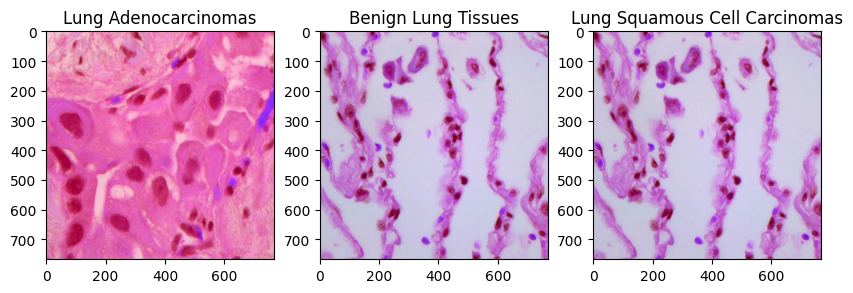

In [11]:
aca = cv2.imread("/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_aca/lungaca1.jpeg", cv2.IMREAD_COLOR)
n = cv2.imread("/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_n/lungn1.jpeg", cv2.IMREAD_COLOR)
scc = cv2.imread("/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_n/lungn1.jpeg", cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(aca)
ax[0].set_title("Lung Adenocarcinomas")
ax[1].imshow(n)
ax[1].set_title('Benign Lung Tissues')
ax[2].imshow(scc)
ax[2].set_title("Lung Squamous Cell Carcinomas")

# Data Preprocessing Pipeline

In [13]:
#load the data
train_x = load_data(train_path)
valid_x = load_data(valid_path)
test_x = load_data(test_path)

In [14]:
print(f'Train:{len(train_x)}  Valid:{len(valid_x)}  Test:{len(test_x)}')

Train:11250  Valid:1875  Test:1875


In [15]:
train_ds = tf_dataset(train_x, batch_size=hp['batch_size'])
valid_ds = tf_dataset(valid_x, batch_size=hp['batch_size'])
test_ds = tf_dataset(test_x, batch_size=hp['batch_size'])

In [16]:
for i,j in train_ds:
    print(i.shape, j.shape)
    break

(32, 512, 512, 3) (32, 3)


In [17]:
imgs, label = next(iter(train_ds))

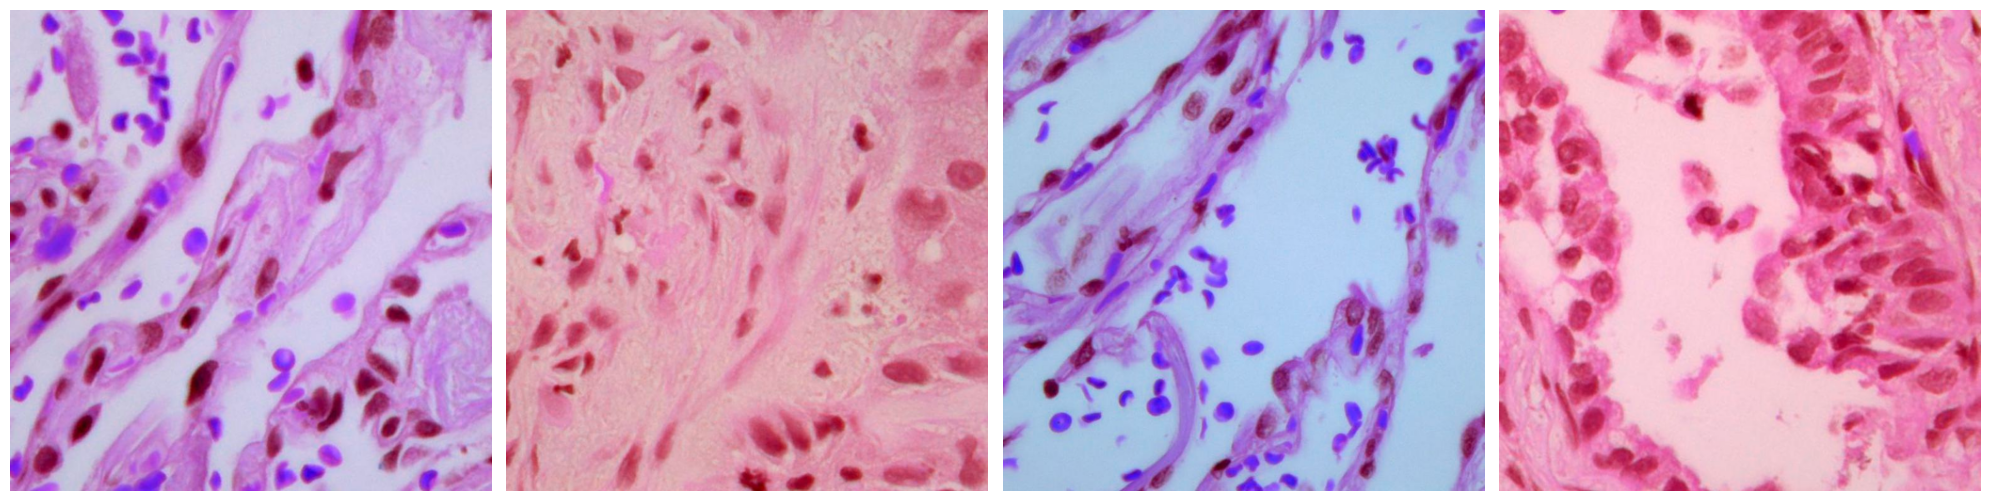

In [18]:
PlotImg(imgs)

# Model

In [19]:
class ClassToken(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        #initial values for the weight
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32), 
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        #reshape
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        #change data type
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls   

In [20]:
def mlp(x, cf):
    x = layers.Dense(cf['mlp_dim'], activation='gelu')(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    x = layers.Dense(cf['hidden_dim'])(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    return x

In [21]:
def transformer_encoder(x, cf):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=cf['num_heads'], key_dim=cf['hidden_dim'])(x,x)
    x = layers.Add()([x, skip_1])
    
    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, cf)
    x = layers.Add()([x, skip_2])
    
    return x

In [22]:
def resnet_block(x, filters, strides=1):
    identity = x

    x = layers.Conv2D(filters, kernel_size=5, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=5, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides > 1:
        identity = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.Activation('relu')(x)
    return x

In [23]:
def build_resnet(input_shape):

    x = layers.Conv2D(32, kernel_size=7, strides=2, padding='same')(input_shape)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = resnet_block(x, filters=32)
    x = resnet_block(x, filters=32)

    x = resnet_block(x, filters=64, strides=2)
    x = resnet_block(x, filters=64)

    x = resnet_block(x, filters=128, strides=2)
    x = resnet_block(x, filters=128)
    
    x = resnet_block(x, filters=256, strides=2)
    x = resnet_block(x, filters=256)
    
    x = resnet_block(x, filters=256, strides=2)
    x = resnet_block(x, filters=256)
    
    return x

In [24]:
def CNN_ViT(hp):
    input_shape = (hp['image_size'], hp['image_size'], hp['num_channels'])
    inputs = layers.Input(input_shape)
    print(inputs.shape)
    output = build_resnet(inputs)
    print(output.shape)

    patch_embed = layers.Conv2D(hp['hidden_dim'], kernel_size=(hp['patch_size']), padding='same')(output)
    print(patch_embed.shape)
    _, h, w, f = output.shape
    patch_embed = layers.Reshape((h*w,f))(output)

    #Position Embedding
    positions = tf.range(start=0, limit=hp['num_patches'], delta=1)
    pos_embed = layers.Embedding(input_dim=hp['num_patches'], output_dim=hp['hidden_dim'])(positions)

    print(f"patch embedding : {patch_embed.shape}")
    print(f"position embeding : {pos_embed.shape}")
    #Patch + Position Embedding
    embed = patch_embed + pos_embed
    
    #Token
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed]) #(None, 257, 256)
    
    #Transformer encoder
    for _ in range(hp['num_layers']):
        x = transformer_encoder(x, hp)
    
    
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    x = layers.Dense(hp['num_classes'], activation='softmax')(x)
    
    model = Model(inputs, x)
    

    return model

In [25]:
model = CNN_ViT(hp)

(None, 512, 512, 3)
(None, 8, 8, 256)
(None, 8, 8, 256)
patch embedding : (None, 64, 256)
position embeding : (64, 256)


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  4736        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [27]:
model.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(hp['lr'], clipvalue=1.0),
              metrics=['acc']
             )

# Training

In [28]:
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

In [30]:
model.fit(
        train_ds,
        epochs=20,
        validation_data=valid_ds,
        callbacks=cbacks
    )

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 0.5690 - acc: 0.7590
Epoch 1: val_loss improved from inf to 3.61382, saving model to /kaggle/working/ViT_for_lung_cancer_classification_v3.h5
352/352 [==============================] - 220s 560ms/step - loss: 0.5690 - acc: 0.7590 - val_loss: 3.6138 - val_acc: 0.3429 - lr: 1.0000e-04
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.3100 - acc: 0.8873
Epoch 2: val_loss improved from 3.61382 to 0.47312, saving model to /kaggle/working/ViT_for_lung_cancer_classification_v3.h5
352/352 [==============================] - 171s 486ms/step - loss: 0.3100 - acc: 0.8873 - val_loss: 0.4731 - val_acc: 0.7632 - lr: 1.0000e-04
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 0.2210 - acc: 0.9169
Epoch 3: val_loss did not improve from 0.47312
352/352 [==============================] - 168s 477ms/step - loss: 0.2210 - acc: 0.9169 - val_loss: 2.3456 - val_acc: 0.5792 - lr: 1.0000e-04
Epoch 4/

In [41]:
saved_model = CNN_ViT(hp)
saved_model.load_weights("/kaggle/working/ViT_for_lung_cancer_classification_v3.h5")
saved_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.Adam(hp["lr"]),
        metrics=["acc"]
    )
saved_model.evaluate(test_ds)

(None, 512, 512, 3)
(None, 8, 8, 256)
(None, 8, 8, 256)
patch embedding : (None, 64, 256)
position embeding : (64, 256)
59/59 [==============================] - 25s 357ms/step - loss: 0.0179 - acc: 0.9941


[0.017853042110800743, 0.9941333532333374]

In [32]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
        print("normalized confusion matrix")

    else:
        print("confusion matrix without normalization")

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.xlabel("predicted label")
        plt.ylabel("True label")

In [34]:
#prediction
prediction = saved_model.predict(test_ds, verbose=0)

In [35]:
#scale the predicted value
np.around(prediction)

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [36]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [37]:
#function for get labels of test set
def get_test_data_class(test_path):
    names = []
    for i in test_path:
        name = i.split("/")[-2]
        name_idx = hp['class_names'].index(name)
        names.append(name_idx)
    names = np.array(names, dtype=np.int32)
    return names

In [48]:
classes = get_test_data_class(test_x)

In [49]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

confusion matrix without normalization


/tmp/ipykernel_32/3594088673.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


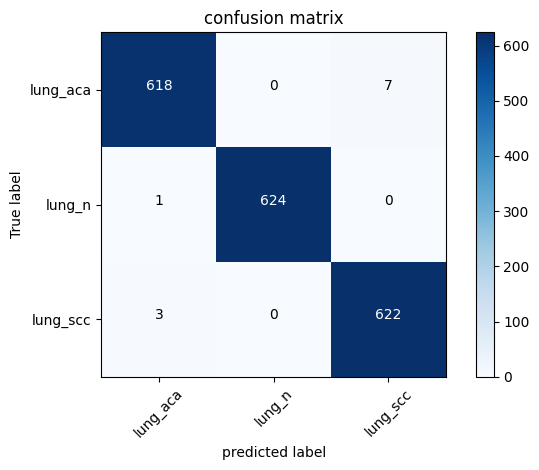

In [50]:
plt_confusion_matrix(cm=cm, classes=hp['class_names'], title="confusion matrix", )

In [51]:
from sklearn.metrics import classification_report
print(classification_report(classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       625
           1       1.00      1.00      1.00       625
           2       0.99      1.00      0.99       625

    accuracy                           0.99      1875
   macro avg       0.99      0.99      0.99      1875
weighted avg       0.99      0.99      0.99      1875

